# Explaining feature importance with Permutation-based Variable Importance (PVI) - Hear Attack Prediction

## Report


### 0. Model training
First a model (Random Forest) was trained on the preprocessed dataset.

### 1. PVI computation
Secondly, PVI for the Random Forest was computed. The following plot shows the six most important features:

![alt text](plots/1.png "PVI for Random Forest")

### 2. PVI for different models

#### Random Forest (max depth = 2)

![alt text](plots/2.png "PVI for Random Forest (shallow)")

#### Logistic Regression

![alt text](plots/3.png "PVI for Random Forest (shallow)")

### 3. PVI comparison with Gini importance and TreeSHAP for Random Forest

#### A) Gini importance (`.feature_importances_`)

![alt text](plots/5.png "Gini importance")

#### B) TreeSHAP

![alt text](plots/6.png "TreeSHAP")

### 6. Final Remarks
All the plots above are commented. Appendix contains the code used to produce the results.

## Appendix

### Install dependencies

In [1]:
!pip install -U pip 'dalex==1.5.0' \
    'shap==0.41.0' 'nbformat>=4.2.0' 'scikit-learn==1.0.2' \
    'pandas==1.3.5' 'numpy==1.22.4' 'lime==0.2.0.1' \
    'alibi==0.8.0' gdown seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


### Download data

In [2]:
import gdown
gdown.download(id='1yBNUVzUAwb5LeQ9eGD55YVPGq-5HoX4c', output='heart.csv', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1yBNUVzUAwb5LeQ9eGD55YVPGq-5HoX4c
To: /home/maciej/Documents/Studia/Zima 2022/XAI/MyRepo/eXplainableMachineLearning-2023/Homeworks/HW5/MaciejPióro/heart.csv
100%|██████████| 11.3k/11.3k [00:00<00:00, 17.6MB/s]


'heart.csv'

### Load & Preprocess data
First the data is loaded and some test set size is selected. To make the analysis reproducible, the seed is set.


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import dalex as dx
import random
import numpy as np
from sklearn.utils import shuffle

SEED = 997
TEST_SIZE = 0.1

data = shuffle(pd.read_csv('heart.csv'), random_state=SEED)

Dataset contains two categorical variable: `cp` and `restecg`. Those are one-hot encoded in preprocessing. Generally models can benefit from one-hot encoding the categorical variables. What's more, we translate and scale the input features to follow the N(0, 1) normal distribution. The data is also split into test and train sets.

In [2]:
from typing import Tuple, Optional
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def to_one_hot(data, column):
    dummies = pd.get_dummies(data[column])
    for dummy_value in dummies.columns:
        data = pd.concat([data, dummies[dummy_value].rename(f'{column}_{dummy_value}')], axis=1)
    return data.drop(column, axis=1)

def scale_dataframe(df: pd.DataFrame, scaler: Optional[StandardScaler] = None) -> Tuple[pd.DataFrame, StandardScaler]:
    res_df = df.copy()
    if scaler is None:
        scaler = StandardScaler()
        scaler = scaler.fit(res_df[res_df.columns])
    res_df[res_df.columns] = scaler.transform(res_df[res_df.columns])
    return res_df, scaler

data = to_one_hot(data, 'cp')
data = to_one_hot(data, 'restecg')

train, test = train_test_split(data, test_size=TEST_SIZE, random_state=SEED)

X_train, train_scaler = scale_dataframe(train.drop(columns=['output']))
y_train = train['output']

X_test, _ = scale_dataframe(test.drop(columns=['output']), train_scaler)
y_test = test['output']

### Train a model
The basic model that we use is Random Forest Classifier

In [10]:
import dalex as dx
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=SEED)

model.fit(X_train, y_train)

tree_model = model

### 1. Calculate PVI for the model

In [11]:
def pf(model, df):
    return model.predict_proba(df)[:, 1]

explainer = dx.Explainer(model, X_test, y_test, predict_function=pf, label='Random Forest')

Preparation of a new explainer is initiated

  -> data              : 31 rows 18 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 31 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : Random Forest
  -> predict function  : <function pf at 0x7ff681756ca0> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.02, mean = 0.462, max = 0.95
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.79, mean = -0.0429, max = 0.78
  -> model_info        : package sklearn

A new explainer has been created!


/home/maciej/Documents/Studia/Zima 2022/XAI/MyRepo/eXplainableMachineLearning-2023/Homeworks/HW5/MaciejPióro/venv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



In [12]:
pvi = explainer.model_parts(random_state=SEED)
pvi.plot(
    max_vars=6, 
    title=None, 
    show=False
)

### 2. Train further models

#### Shallow Random Forest Classifier

In [13]:
def pf(model, df):
    return model.predict_proba(df)[:, 1]

model = RandomForestClassifier(random_state=SEED, max_depth=2)

model.fit(X_train, y_train)

explainer = dx.Explainer(model, X_test, y_test, predict_function=pf, label='Random Forest (shallow)')
pvi = explainer.model_parts(random_state=SEED)
pvi.plot(
    max_vars=6, 
    title=None, 
    show=True
)

Preparation of a new explainer is initiated

  -> data              : 31 rows 18 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 31 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : Random Forest (shallow)
  -> predict function  : <function pf at 0x7ff68176bf70> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.162, mean = 0.488, max = 0.843
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.706, mean = -0.0687, max = 0.615
  -> model_info        : package sklearn

A new explainer has been created!


/home/maciej/Documents/Studia/Zima 2022/XAI/MyRepo/eXplainableMachineLearning-2023/Homeworks/HW5/MaciejPióro/venv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



#### Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegression

def pf(model, df):
    return model.predict_proba(df)[:, 1]

model = LogisticRegression(random_state=SEED)

model.fit(X_train, y_train)

explainer = dx.Explainer(model, X_test, y_test, predict_function=pf, label='Logistic Regression')
pvi = explainer.model_parts(random_state=SEED)
pvi.plot(
    max_vars=6, 
    title=None, 
    show=True
)

Preparation of a new explainer is initiated

  -> data              : 31 rows 18 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 31 values
  -> model_class       : sklearn.linear_model._logistic.LogisticRegression (default)
  -> label             : Logistic Regression
  -> predict function  : <function pf at 0x7ff68176b5e0> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.00155, mean = 0.459, max = 0.994
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.882, mean = -0.0395, max = 0.92
  -> model_info        : package sklearn

A new explainer has been created!


/home/maciej/Documents/Studia/Zima 2022/XAI/MyRepo/eXplainableMachineLearning-2023/Homeworks/HW5/MaciejPióro/venv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but LogisticRegression was fitted with feature names



#### KNN

In [17]:
from sklearn.neighbors import KNeighborsClassifier

def pf(model, df):
    return model.predict_proba(df)[:, 1]

model = KNeighborsClassifier(n_neighbors=5)

model.fit(X_train, y_train)

explainer = dx.Explainer(model, X_test, y_test, predict_function=pf, label='KNN')
pvi = explainer.model_parts(random_state=SEED)
pvi.plot(
    max_vars=6, 
    title=None,
    show=True
)

Preparation of a new explainer is initiated

  -> data              : 31 rows 18 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 31 values
  -> model_class       : sklearn.neighbors._classification.KNeighborsClassifier (default)
  -> label             : KNN
  -> predict function  : <function pf at 0x7ff681754b80> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 0.477, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.8, mean = -0.0581, max = 1.0
  -> model_info        : package sklearn

A new explainer has been created!


/home/maciej/Documents/Studia/Zima 2022/XAI/MyRepo/eXplainableMachineLearning-2023/Homeworks/HW5/MaciejPióro/venv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names



### 3. PVI comparison with other feature importance metrics

#### `.feature_importances_` from sklearn

[Text(0.5, 1.0, 'Feature importance (sklearn .feature_importances_)')]

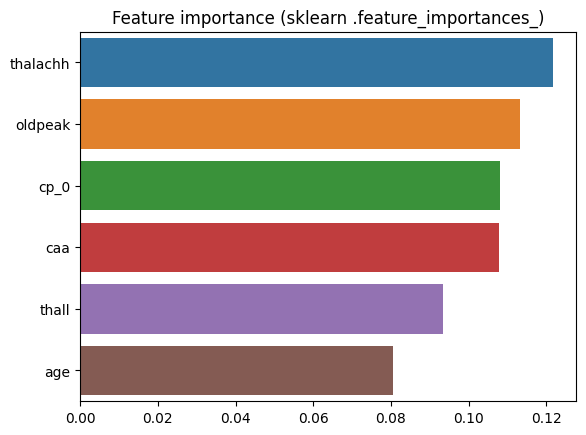

In [21]:
def topk_index(array: np.array, k: int):
    return (-tree_model.feature_importances_).argsort()[:6]

idx = topk_index(tree_model.feature_importances_, 6)
sns.barplot(
    x=tree_model.feature_importances_[idx],
    y=tree_model.feature_names_in_[idx]
).set(title='Feature importance (sklearn .feature_importances_)')

#### TreeSHAP

/home/maciej/Documents/Studia/Zima 2022/XAI/MyRepo/eXplainableMachineLearning-2023/Homeworks/HW5/MaciejPióro/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



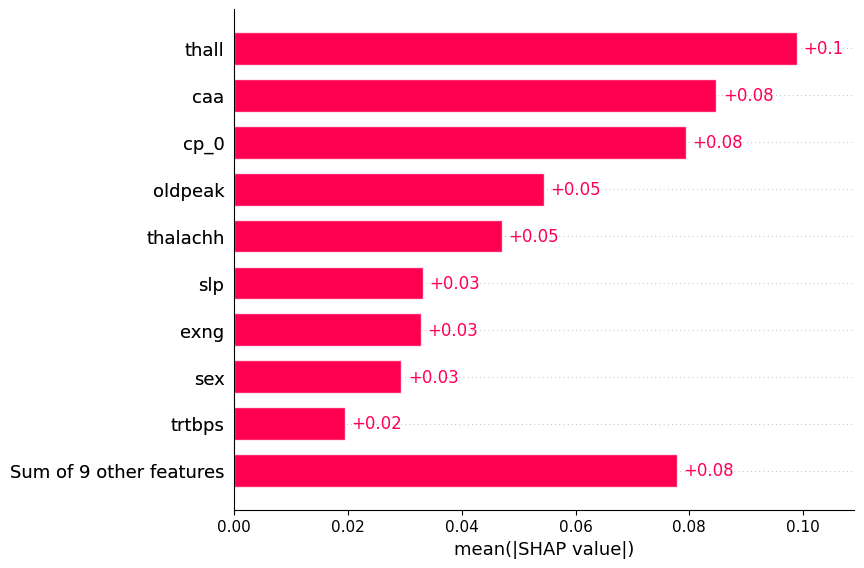

In [19]:
import shap
shap_explainer = shap.explainers.Tree(tree_model, data=X_train, model_output='probability', random_state=SEED)
shap_values = shap_explainer(X_test)
shap.plots.bar(shap_values.abs.mean(0)[:, 1])